## Imports and Loading Embeddings File

In [1]:
import sys
print(sys.executable)

E:\Program Files (x86)\Anaconda3\envs\dissertation\python.exe


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling1D, AveragePooling1D, Embedding, GlobalMaxPooling1D, Conv1D, GlobalAveragePooling1D, MaxPool1D, concatenate, Activation, Input

from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer 
import numpy as np
sys.path.append('..\Scripts')
import helperfn as hf
import graphs as gh
%load_ext autoreload
%autoreload 2

In [3]:
from gensim.models import KeyedVectors
embedding_model = KeyedVectors.load_word2vec_format('..\word2vec\GoogleNews-vectors-negative300.bin', binary=True)
# If we don't plan to train the model any further, calling init_sims will make the model much more memory-efficient.
embedding_model.init_sims(replace=True)

## Loading and Pre-processing the dataset

In [4]:
stop = hf.stop_words()
uni_names = hf.uni_names()

#Get Data
data = hf.merge_datasets(r'E:\GitHubProjects\dissertation\scraper\approved_datasets')
# data = hf.balance_dataset(data)

#Tokenize the text using NLTK
tokenizer = RegexpTokenizer(r'([\w\']+|\[+|]+|\!+|"+|\$+|%+|&+|\'+|\(+|\)+|\*+|\++|,+|\.+|:+|;+|=+|#+|@+|\?+|\[+|\^+|_+|`+|{+|\|+|\}+|~+|-+|]+)') 

data['tokenized_text'] = data['review'].apply(lambda x: tokenizer.tokenize(x)) 

#lower case
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: hf.lower_token(x))

#remove stop words
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: [item for item in x if item not in stop])

#remove university names as they impact accuracy, these words should be neutral sentiment 
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: [item for item in x if item not in uni_names])

#reduce puncuations, remove duplicates next to each other and leave only one e.g. !!! to !
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: hf.remove_punctuations(x))

#lemmatization
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: hf.lemmatization(x))

X, y = data['tokenized_text'], list(data['score'])

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence

#vocab size
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

#finding the maximum number of words the longests sentence contains
#VERSION FOR TOKENIZED ROWS
longest = 0
for x in X:
    if len(x) > longest:
        longest = len(x)

#padding sequences to have the same length
x_train_seq = pad_sequences(sequences, maxlen=longest+5)

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(x_train_seq, y, test_size=0.2, shuffle=True, stratify=y, random_state=8)
#Converting from list to numPy arrays (fixed errors after tensorflow... imports)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [7]:
#Word Embeddings
#length of vectors in embedding word2vec
embedding_vecor_length = 300
embedding_matrix = np.zeros((NUM_WORDS, embedding_vecor_length))

for word, i in tokenizer.word_index.items():
    if i >= NUM_WORDS:
        continue
    try:
        embedding_vector = embedding_model[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        pass

## Simple Network

Best network we found with 91.75% accuracy and 45-60 missed predictions (depending on run).
Uses 4 epochs before showing signs of over-fitting

In [17]:
model_cnn = Sequential()
e = Embedding(NUM_WORDS, 300, weights=[embedding_matrix], input_length=longest+5, trainable=False)
model_cnn.add(e)
model_cnn.add(Dropout(0.3))
model_cnn.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu', strides=1))
model_cnn.add(MaxPooling1D(4))
model_cnn.add(Conv1D(filters=256, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn.add(MaxPooling1D(1))
model_cnn.add(Conv1D(filters=224, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn.add(AveragePooling1D(1))
model_cnn.add(Dropout(0.05))
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit_obj = model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, batch_size=32, verbose=2)

# from sklearn.metrics import confusion_matrix
# y_pred = (model_cnn.predict(X_test).ravel()>0.5)+0 # predict and get class (0 if pred < 0.5 else 1)
# tp, fp, fn, tn = confusion_matrix(y_test, y_pred, labels=[1, 0]).ravel()
# conf = confusion_matrix(y_test, y_pred, labels=[1, 0])
# gh.conf_matrix(conf)

# accuracy = (tp+tn) / (tp+tn+fp+fn) 
# precision = tp / (tp+fp)
# recall = tp / (tp+fn)
# print("Accuracy: ", round(accuracy, 4))
# print("Precision: ", round(precision, 4))
# print("Recall: ", round(recall, 4))
# print("F1-score: ", round((2*precision*recall) / (precision+recall), 4))
# print("wrong: ", fn+fp)

Train on 2277 samples, validate on 570 samples
Epoch 1/4
2277/2277 - 3s - loss: 0.5356 - accuracy: 0.7470 - val_loss: 0.3099 - val_accuracy: 0.8719
Epoch 2/4
2277/2277 - 2s - loss: 0.3141 - accuracy: 0.8634 - val_loss: 0.2795 - val_accuracy: 0.8860
Epoch 3/4
2277/2277 - 2s - loss: 0.2563 - accuracy: 0.8911 - val_loss: 0.2357 - val_accuracy: 0.9035
Epoch 4/4
2277/2277 - 2s - loss: 0.2215 - accuracy: 0.9065 - val_loss: 0.2151 - val_accuracy: 0.9263


## Network with multi n-grams

Provides more consistent results than Simple Network with 92% accuracy which is 44-52 missed predictions.
Converges faster at 2 epochs 

In [8]:
tweet_input = Input(shape=(longest+5,), dtype='int32')
tweet_encoder = Embedding(NUM_WORDS, 300, weights=[embedding_matrix], input_length=longest+5, trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=160, kernel_size=2, padding='valid', activation='elu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=96, kernel_size=3, padding='valid', activation='selu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=224, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.21)(merged)
merged = Flatten()(merged)
merged = Dense(128, activation='relu')(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=32, verbose=2)

# from sklearn.metrics import confusion_matrix
# y_pred = (model.predict(X_test).ravel()>0.5)+0 # predict and get class (0 if pred < 0.5 else 1)
# tp, fp, fn, tn = confusion_matrix(y_test, y_pred, labels=[1, 0]).ravel()
# conf = confusion_matrix(y_test, y_pred, labels=[1, 0])
# gh.conf_matrix(conf)

# accuracy = (tp+tn) / (tp+tn+fp+fn) 
# precision = tp / (tp+fp)
# recall = tp / (tp+fn)
# print("Accuracy: ", round(accuracy, 4))
# print("Precision: ", round(precision, 4))
# print("Recall: ", round(recall, 4))
# print("F1-score: ", round((2*precision*recall) / (precision+recall), 4))
# print("wrong: ", fn+fp)

Train on 2277 samples, validate on 570 samples
Epoch 1/2
2277/2277 - 15s - loss: 0.1302 - accuracy: 0.8256 - val_loss: 0.0718 - val_accuracy: 0.9088
Epoch 2/2
2277/2277 - 1s - loss: 0.0585 - accuracy: 0.9284 - val_loss: 0.0609 - val_accuracy: 0.9193


### Bias-variance tradeoff

In [18]:
from mlxtend.evaluate import bias_variance_decomp
# Test the model after training
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

# Using Mlxtend to decompose loss
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model_cnn, X_train, y_train, X_test, y_test, 
        loss='mse',
        epochs=4,
        num_rounds=50,
        random_seed=46)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

s/sample - loss: 0.1971 - accuracy: 0.9170
Train on 2277 samples
Epoch 1/4
2277/2277 [==============================] - 2s 685us/sample - loss: 0.6001 - accuracy: 0.7040
Epoch 2/4
2277/2277 [==============================] - 2s 702us/sample - loss: 0.3982 - accuracy: 0.8072
Epoch 3/4
2277/2277 [==============================] - 2s 733us/sample - loss: 0.2718 - accuracy: 0.8836
Epoch 4/4
2277/2277 [==============================] - 2s 700us/sample - loss: 0.2036 - accuracy: 0.9152
Train on 2277 samples
Epoch 1/4
2277/2277 [==============================] - 2s 695us/sample - loss: 0.6006 - accuracy: 0.7084
Epoch 2/4
2277/2277 [==============================] - 2s 690us/sample - loss: 0.3507 - accuracy: 0.8551
Epoch 3/4
2277/2277 [==============================] - 2s 713us/sample - loss: 0.2556 - accuracy: 0.8981
Epoch 4/4
2277/2277 [==============================] - 2s 672us/sample - loss: 0.2017 - accuracy: 0.9267
Train on 2277 samples
Epoch 1/4
2277/2277 [==============================

## Testing N-gram with multiple brnahces with hyperparams from tuner

In [9]:
# TESTING MOREEACH BRNAHC TO HAVE 3 PAIRS
tweet_input = Input(shape=(longest+5,), dtype='int32')

tweet_encoder = Embedding(NUM_WORDS, 300, weights=[embedding_matrix], input_length=longest+5, trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=192, kernel_size=2, padding='valid', activation='elu', strides=1)(tweet_encoder)
bigram_branch = MaxPooling1D(3)(bigram_branch)
bigram_branch = Conv1D(filters=128, kernel_size=2, padding='valid', activation='elu', strides=1)(bigram_branch)
bigram_branch = MaxPooling1D(2)(bigram_branch)
# bigram_branch = Conv1D(filters=224, kernel_size=2, padding='valid', activation='elu', strides=1)(bigram_branch)
# bigram_branch = MaxPooling1D(4)(bigram_branch)
bigram_branch = Flatten()(bigram_branch)

trigram_branch = Conv1D(filters=192, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = MaxPooling1D(1)(trigram_branch)
trigram_branch = Conv1D(filters=160, kernel_size=3, padding='valid', activation='selu', strides=1)(trigram_branch)
trigram_branch = MaxPooling1D(1)(trigram_branch)
# trigram_branch = Conv1D(filters=192, kernel_size=3, padding='valid', activation='selu', strides=1)(trigram_branch)
# trigram_branch = MaxPooling1D(1)(trigram_branch)
trigram_branch = Flatten()(trigram_branch)

fourgram_branch = Conv1D(filters=128, kernel_size=4, padding='valid', activation='tanh', strides=1)(tweet_encoder)
fourgram_branch = MaxPooling1D(3)(fourgram_branch)
fourgram_branch = Conv1D(filters=256, kernel_size=4, padding='valid', activation='selu', strides=1)(fourgram_branch)
fourgram_branch = MaxPooling1D(4)(fourgram_branch)
# fourgram_branch = Conv1D(filters=160, kernel_size=4, padding='valid', activation='selu', strides=1)(fourgram_branch)
# fourgram_branch = MaxPooling1D(2)(fourgram_branch)
fourgram_branch = Flatten()(fourgram_branch)

merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.24)(merged)
merged = Flatten()(merged)
merged = Dense(256, activation='relu')(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
fit_obj = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=32, verbose=2)

Train on 2277 samples, validate on 570 samples
Epoch 1/2
2277/2277 - 14s - loss: 0.4075 - accuracy: 0.8155 - val_loss: 0.3020 - val_accuracy: 0.8754
Epoch 2/2
2277/2277 - 1s - loss: 0.2011 - accuracy: 0.9152 - val_loss: 0.2467 - val_accuracy: 0.9070


## Tuner for Multi n-grams Network

In [9]:
%%capture

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(hp=None):
    tweet_input = Input(shape=(longest+5,), dtype='int32')
    tweet_encoder = Embedding(NUM_WORDS, 300, weights=[embedding_matrix], input_length=longest+5, trainable=False)(tweet_input)
    tweet_encoder = Dropout(hp.Float(f'dropout_start', min_value=0.0, max_value=0.3, step=0.1))(tweet_encoder)
    bigram_branch = Conv1D(filters=hp.Int(f'conv_filters_bigram', min_value=64, max_value=256, step=32), kernel_size=4, padding='valid', activation=hp.Choice('conv_activation_bigram', values=['relu', 'selu', 'elu', 'tanh']), strides=1)(tweet_encoder)
    bigram_branch = GlobalMaxPooling1D()(bigram_branch)
    trigram_branch = Conv1D(filters=hp.Int(f'conv_filters_trigram', min_value=64, max_value=256, step=32), kernel_size=3, padding='valid', activation=hp.Choice('conv_activation_trigram', values=['relu', 'selu', 'elu', 'tanh']), strides=1)(tweet_encoder)
    trigram_branch = GlobalMaxPooling1D()(trigram_branch)
    fourgram_branch = Conv1D(filters=hp.Int(f'conv_filters_fourgram', min_value=64, max_value=256, step=32), kernel_size=2, padding='valid', activation=hp.Choice('conv_activation_fourgram', values=['relu', 'selu', 'elu', 'tanh']), strides=1)(tweet_encoder)
    fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
    merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

    merged = Dropout(hp.Float(f'dropout_end', min_value=0.0, max_value=0.3, step=0.1))(merged)
    merged = Dense(hp.Int(f'last_dense', min_value=32, max_value=256, step=32), activation='relu')(merged)
    merged = Dense(1)(merged)
    output = Activation('sigmoid')(merged)
    model = Model(inputs=[tweet_input], outputs=[output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

tuner = BayesianOptimization(
    build_model,
    objective= 'val_accuracy',
    max_trials = 70,
    executions_per_trial = 2,
    directory = 'bayesian_search2',
    project_name='multi_ngrams_2epochs',
    overwrite = True
)

callback = [EarlyStopping(monitor='val_loss', patience=1)]

tuner.search(
    x=X_train,
    y=y_train,
    epochs=2,
    batch_size=64,
    verbose=0,
    callbacks=callback,
    validation_data=(X_test, y_test)
)

INFO:tensorflow:Oracle triggered exit


## Tuner for Multi n-gram multiple pairs

In [13]:
%%capture

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(hp=None):
    tweet_input = Input(shape=(longest+5,), dtype='int32')

    tweet_encoder = Embedding(NUM_WORDS, 300, weights=[embedding_matrix], input_length=longest+5, trainable=False)(tweet_input)
    # tweet_encoder = Dropout(hp.Float(f'dropout_start', min_value=0.0, max_value=0.3, step=0.1))(tweet_encoder)

    bigram_branch = Conv1D(filters=hp.Int(f'conv_filters_bigram1', min_value=64, max_value=256, step=32), kernel_size=4, padding='valid', activation=hp.Choice('conv_activation_bigram1', values=['relu', 'selu', 'elu', 'tanh']), strides=1)(tweet_encoder)
    bigram_branch = MaxPooling1D(hp.Int(f'maxPooling_bigram1', min_value=1, max_value=4, step=1), padding='same')(bigram_branch)
    bigram_branch = Conv1D(filters=hp.Int(f'conv_filters_bigram2', min_value=64, max_value=256, step=32), kernel_size=4, padding='valid', activation=hp.Choice('conv_activation_bigram2', values=['relu', 'selu', 'elu', 'tanh']), strides=1)(tweet_encoder)
    bigram_branch = MaxPooling1D(hp.Int(f'maxPooling_bigram2', min_value=1, max_value=4, step=1), padding='same')(bigram_branch)
    bigram_branch = Conv1D(filters=hp.Int(f'conv_filters_bigram3', min_value=64, max_value=256, step=32), kernel_size=4, padding='valid', activation=hp.Choice('conv_activation_bigram3', values=['relu', 'selu', 'elu', 'tanh']), strides=1)(tweet_encoder)
    bigram_branch = MaxPooling1D(hp.Int(f'maxPooling_bigram3', min_value=1, max_value=4, step=1), padding='same')(bigram_branch)
    bigram_branch = Flatten()(bigram_branch)

    trigram_branch = Conv1D(filters=hp.Int(f'conv_filters_trigram1', min_value=64, max_value=256, step=32), kernel_size=3, padding='valid', activation=hp.Choice('conv_activation_trigram1', values=['relu', 'selu', 'elu', 'tanh']), strides=1)(tweet_encoder)
    trigram_branch = MaxPooling1D(hp.Int(f'maxPooling_trigram1', min_value=1, max_value=4, step=1), padding='same')(trigram_branch)
    trigram_branch = Conv1D(filters=hp.Int(f'conv_filters_trigram2', min_value=64, max_value=256, step=32), kernel_size=3, padding='valid', activation=hp.Choice('conv_activation_trigram2', values=['relu', 'selu', 'elu', 'tanh']), strides=1)(trigram_branch)
    trigram_branch = MaxPooling1D(hp.Int(f'maxPooling_trigram2', min_value=1, max_value=4, step=1), padding='same')(trigram_branch)
    trigram_branch = Conv1D(filters=hp.Int(f'conv_filters_trigram3', min_value=64, max_value=256, step=32), kernel_size=3, padding='valid', activation=hp.Choice('conv_activation_trigram3', values=['relu', 'selu', 'elu', 'tanh']), strides=1)(trigram_branch)
    trigram_branch = MaxPooling1D(hp.Int(f'maxPooling_trigram3', min_value=1, max_value=4, step=1), padding='same')(trigram_branch)
    trigram_branch = Flatten()(trigram_branch)

    fourgram_branch = Conv1D(filters=hp.Int(f'conv_filters_fourgram', min_value=64, max_value=256, step=32), kernel_size=2, padding='valid', activation=hp.Choice('conv_activation_fourgram', values=['relu', 'selu', 'elu', 'tanh']), strides=1)(tweet_encoder)
    fourgram_branch = MaxPooling1D(hp.Int(f'maxPooling_fourgram1', min_value=1, max_value=4, step=1), padding='same')(fourgram_branch)
    fourgram_branch = Conv1D(filters=hp.Int(f'conv_filters_fourgram2', min_value=64, max_value=256, step=32), kernel_size=2, padding='valid', activation=hp.Choice('conv_activation_fourgram2', values=['relu', 'selu', 'elu', 'tanh']), strides=1)(fourgram_branch)
    fourgram_branch = MaxPooling1D(hp.Int(f'maxPooling_fourgram2', min_value=1, max_value=4, step=1), padding='same')(fourgram_branch)
    fourgram_branch = Conv1D(filters=hp.Int(f'conv_filters_fourgram3', min_value=64, max_value=256, step=32), kernel_size=2, padding='valid', activation=hp.Choice('conv_activation_fourgram3', values=['relu', 'selu', 'elu', 'tanh']), strides=1)(fourgram_branch)
    fourgram_branch = MaxPooling1D(hp.Int(f'maxPooling_fourgram3', min_value=1, max_value=4, step=1), padding='same')(fourgram_branch)
    fourgram_branch = Flatten()(fourgram_branch)

    merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)
    merged = Dropout(hp.Float(f'dropout_end', min_value=0.0, max_value=0.3, step=0.05))(merged)
    merged = Dense(hp.Int(f'last_dense', min_value=32, max_value=256, step=32), activation='relu')(merged)
    merged = Dense(1)(merged)
    output = Activation('sigmoid')(merged)
    model = Model(inputs=[tweet_input], outputs=[output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


tuner = BayesianOptimization(
    build_model,
    objective= 'val_accuracy',
    max_trials = 150,
    executions_per_trial = 2,
    directory = 'bayesian_search2',
    project_name='multi_ngrams_pairs_2epochs',
    overwrite = True
)

callback = [EarlyStopping(monitor='val_loss', patience=1)]

tuner.search(
    x=X_train,
    y=y_train,
    epochs=2,
    batch_size=64,
    verbose=0,
    callbacks=callback,
    validation_data=(X_test, y_test)
)

INFO:tensorflow:Oracle triggered exit


## Testing multi n-gram but with SVM
### First cell using sklearn. 2nd cell version with Keras

In [8]:
tweet_input = Input(shape=(longest+5,), dtype='int32')

tweet_encoder = Embedding(NUM_WORDS, 300, weights=[embedding_matrix], input_length=longest+5, trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=160, kernel_size=2, padding='valid', activation='elu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=96, kernel_size=3, padding='valid', activation='selu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=224, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
feature_extractor = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)
# dense to match input shape
feature_extractor = Dense(137)(feature_extractor)
merged = Dropout(0.21)(feature_extractor)
merged = Flatten()(merged)
merged = Dense(128, activation='relu')(merged)
merged = Dense(1)(merged)
prediction_layer = Dense(1, activation = 'sigmoid')(merged)

model = Model(inputs=[tweet_input], outputs=[prediction_layer])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train full network, both using features and classifier
fit_obj = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=32, verbose=2)

# predict only using feature exctraction model
features_model = Model(inputs=model.layers[0].input, outputs=model.layers[9].output)
X_features = features_model.predict(X_train)

# from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.metrics import accuracy_score
svc = svm.SVC(kernel='linear', max_iter=-1)

# train SVM on extracted features
clf =svc.fit(X_features, y_train)
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

Train on 2277 samples, validate on 570 samples
Epoch 1/2
2277/2277 - 13s - loss: 0.3932 - accuracy: 0.8147 - val_loss: 0.2471 - val_accuracy: 0.9035
Epoch 2/2
2277/2277 - 1s - loss: 0.1642 - accuracy: 0.9407 - val_loss: 0.2764 - val_accuracy: 0.8965


0.45087719298245615

In [41]:
#nulti n-gram with SVM (Keras SVM)
tweet_input = Input(shape=(longest+5,), dtype='int32')

tweet_encoder = Embedding(NUM_WORDS, 300, weights=[embedding_matrix], input_length=longest+5, trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=160, kernel_size=2, padding='valid', activation='elu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=96, kernel_size=3, padding='valid', activation='selu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=224, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dropout(0.21)(merged)
merged = Flatten()(merged)
merged = Dense(256, activation='relu')(merged)

merged = Dense(1, kernel_regularizer=regularizers.l2(0.01))(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='hinge',
              optimizer='adadelta',
              metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=32, verbose=2)

Train on 2277 samples, validate on 570 samples
Epoch 1/2
2277/2277 - 3s - loss: 0.8270 - accuracy: 0.6675 - val_loss: 0.8263 - val_accuracy: 0.6684
Epoch 2/2
2277/2277 - 1s - loss: 0.8261 - accuracy: 0.6675 - val_loss: 0.8252 - val_accuracy: 0.6684


## Tuner for Simple Network

In [15]:
%%capture

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(hp=None):
    model_cnn = Sequential()
    e = Embedding(NUM_WORDS, 300, weights=[embedding_matrix], input_length=longest+5, trainable=False)
    model_cnn.add(e)
    model_cnn.add(Dropout(hp.Float(f'dropout_start', min_value=0.0, max_value=0.3, step=0.1)))

    model_cnn.add(Conv1D(filters=hp.Int(f'conv_filters_1', min_value=64, max_value=256, step=32), kernel_size=hp.Int(f'conv_kernel_size_1', min_value=1, max_value=3, step=1), padding='valid', activation=hp.Choice('conv_activation_1', values=['relu', 'selu', 'elu', 'tanh']), strides=hp.Int(f'conv_strides_1', min_value=1, max_value=3, step=1)))
    model_cnn.add(MaxPooling1D(hp.Int(f'maxPooling_1', min_value=1, max_value=4, step=1), padding='same'))

    model_cnn.add(Conv1D(filters=hp.Int(f'conv_filters_2', min_value=64, max_value=256, step=32), kernel_size=hp.Int(f'conv_kernel_size_2', min_value=1, max_value=3, step=1), padding='valid', activation=hp.Choice('conv_activation_2', values=['relu', 'selu', 'elu', 'tanh']), strides=hp.Int(f'conv_strides_2', min_value=1, max_value=3, step=1)))
    model_cnn.add(MaxPooling1D(hp.Int(f'maxPooling_2', min_value=1, max_value=4, step=1), padding='same'))

    model_cnn.add(Conv1D(filters=hp.Int(f'conv_filters_3', min_value=64, max_value=256, step=32), kernel_size=hp.Int(f'conv_kernel_size_3', min_value=1, max_value=3, step=1), padding='valid', activation=hp.Choice('conv_activation_3', values=['relu', 'selu', 'elu', 'tanh']), strides=hp.Int(f'conv_strides_3', min_value=1, max_value=3, step=1)))
    model_cnn.add(MaxPooling1D(hp.Int(f'maxPooling_3', min_value=1, max_value=4, step=1), padding='same'))

    model_cnn.add(Dropout(hp.Float(f'dropout_end', min_value=0.0, max_value=0.3, step=0.1)))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(hp.Int(f'last_dense', min_value=32, max_value=256, step=32), activation='relu'))
    model_cnn.add(Dense(1, activation='sigmoid'))
    model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_cnn

tuner = BayesianOptimization(
    build_model,
    objective= 'val_accuracy',
    max_trials = 50,
    executions_per_trial = 2,
    directory = 'bayesian_search2',
    project_name='threeConvMaxPooling',
    overwrite = True
)

callback = [EarlyStopping(monitor='val_loss', patience=1)]

tuner.search(
    x=X_train,
    y=y_train,
    epochs=8,
    batch_size=64,
    verbose=0,
    callbacks=callback,
    validation_data=(X_test, y_test)
)

INFO:tensorflow:Oracle triggered exit


## Cell below used to check for signs of overfitting

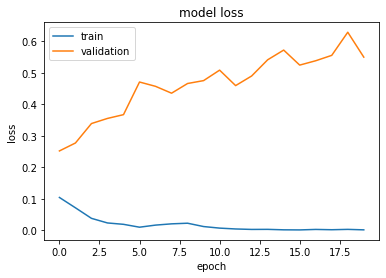

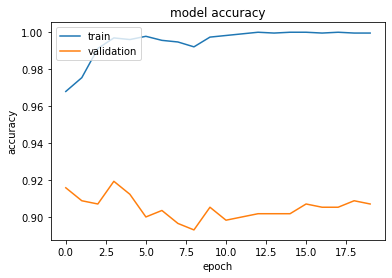

In [14]:
gh.model_loss(fit_obj)
gh.model_accuracy(fit_obj)

## Confusion Matrix and Metrics

In [13]:
accuracy = (tp+tn) / (tp+tn+fp+fn) 
precision = tp / (tp+fp)
recall = tp / (tp+fn)
print("Accuracy: ", round(accuracy, 4))
print("Precision: ", round(precision, 4))
print("Recall: ", round(recall, 4))
print("F1-score: ", round((2*precision*recall) / (precision+recall), 4))
print("wrong: ", fn+fp)

Precision:  0.9401041666666666
Recall:  0.94750656167979


## Exporting tokenizer and trained model to store as files

In [6]:
import pickle as pk
# saving the tokenizer
with open('tokenizer_lemmatization.pickle', 'wb') as handle:
    pk.dump(tokenizer, handle, protocol=pk.HIGHEST_PROTOCOL)
    
# model.save("model_exported.h5")

## Plotting tuner runs with kt2hip 

In [ ]:
# create CSV - python kt2hip.py bayesian_search2/oneConvMaxPooling
import hiplot as hip
iris_hiplot = hip.Experiment.from_csv("bayesian_search2\/twoConvMaxPooling\hiplot.csv")
iris_hiplot.display()